#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "word2vec-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model12(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model12, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1, 0, 2)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)        
        return out
    

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 48.15batch/s, loss=0.0156]


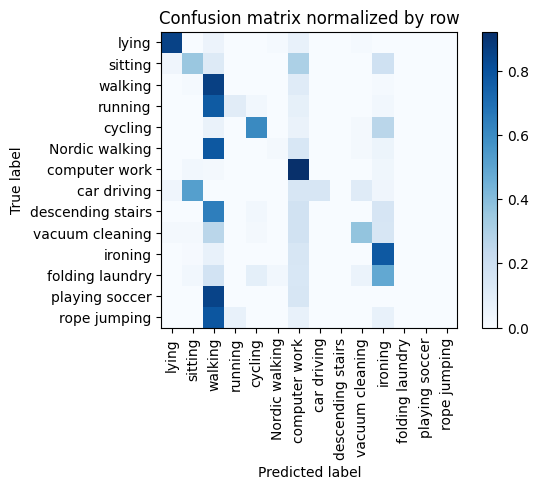

Training Epoch:  10%|█         | 1/10 [00:08<01:19,  8.87s/it]

Overall accuracy: 0.508



eval: 100%|██████████| 26/26 [00:00<00:00, 45.93batch/s, loss=0.0138]


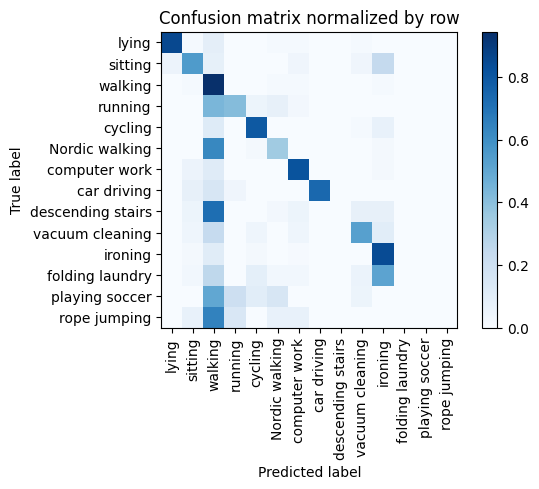

Training Epoch:  20%|██        | 2/10 [00:13<00:52,  6.58s/it]

Overall accuracy: 0.617



eval: 100%|██████████| 26/26 [00:00<00:00, 48.03batch/s, loss=0.0161]


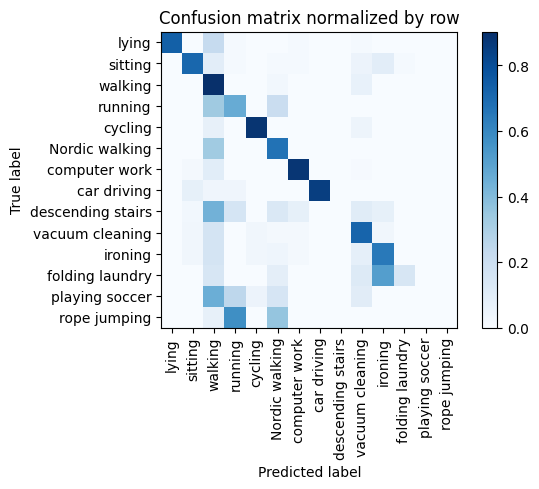

Training Epoch:  30%|███       | 3/10 [00:18<00:41,  5.88s/it]

Overall accuracy: 0.663



eval: 100%|██████████| 26/26 [00:00<00:00, 49.10batch/s, loss=0.00814]


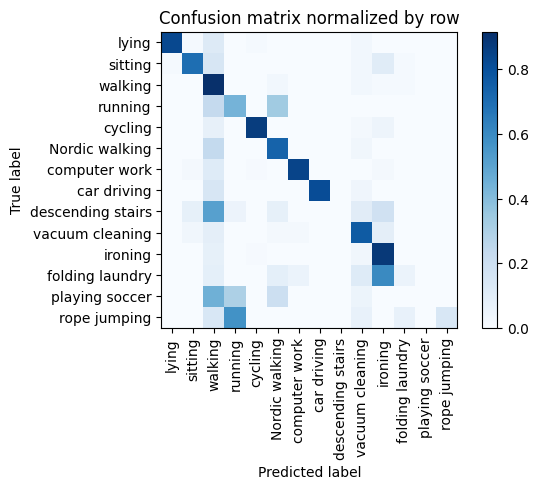

Training Epoch:  40%|████      | 4/10 [00:23<00:33,  5.53s/it]

Overall accuracy: 0.699



eval: 100%|██████████| 26/26 [00:00<00:00, 48.87batch/s, loss=0.00752]


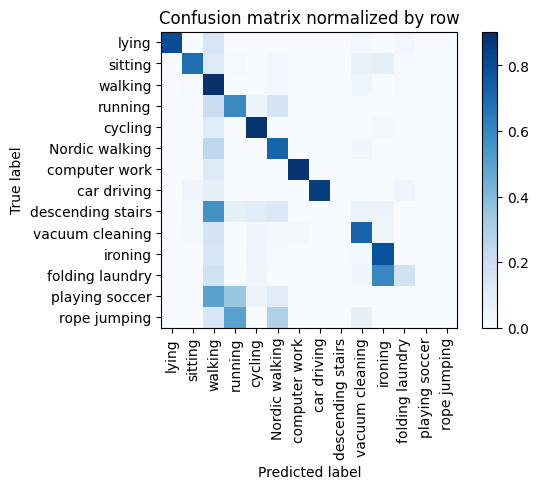

Training Epoch:  50%|█████     | 5/10 [00:29<00:27,  5.41s/it]

Overall accuracy: 0.696



eval: 100%|██████████| 26/26 [00:00<00:00, 41.53batch/s, loss=0.0115]


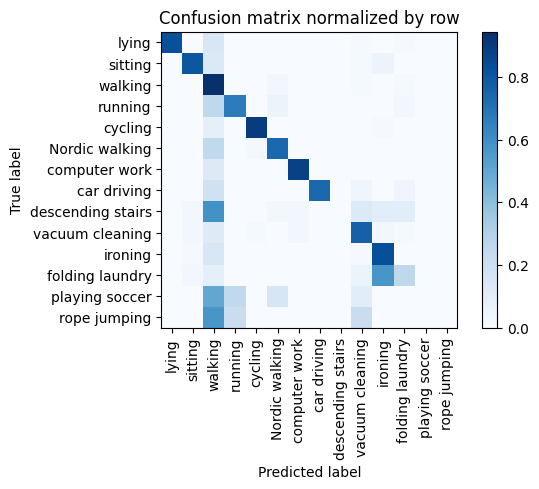

Training Epoch:  60%|██████    | 6/10 [00:34<00:21,  5.34s/it]

Overall accuracy: 0.728



eval: 100%|██████████| 26/26 [00:00<00:00, 48.86batch/s, loss=0.0121]


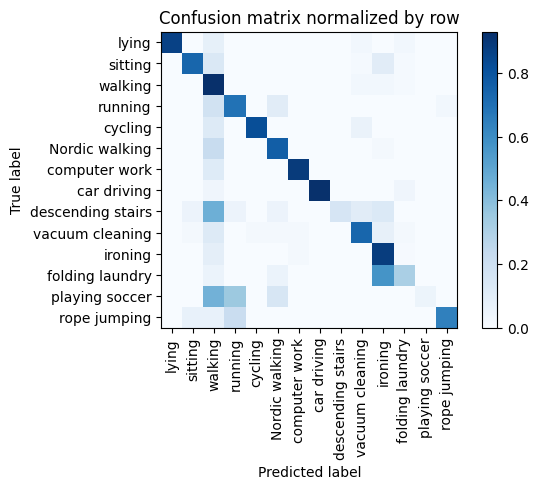

Training Epoch:  70%|███████   | 7/10 [00:40<00:16,  5.46s/it]

Overall accuracy: 0.755



eval: 100%|██████████| 26/26 [00:00<00:00, 43.48batch/s, loss=0.00651]


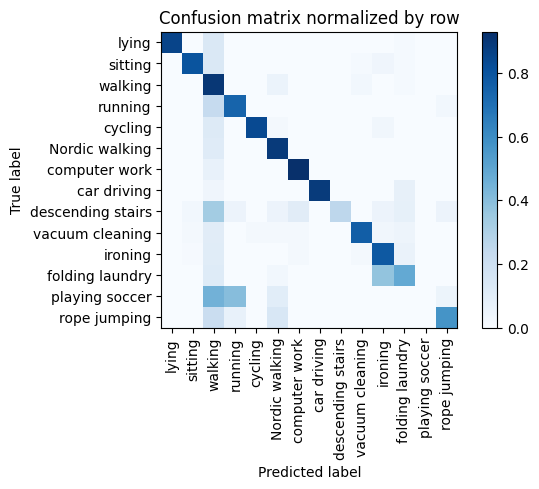

Training Epoch:  80%|████████  | 8/10 [00:46<00:11,  5.84s/it]

Overall accuracy: 0.775



eval: 100%|██████████| 26/26 [00:00<00:00, 46.87batch/s, loss=0.007]


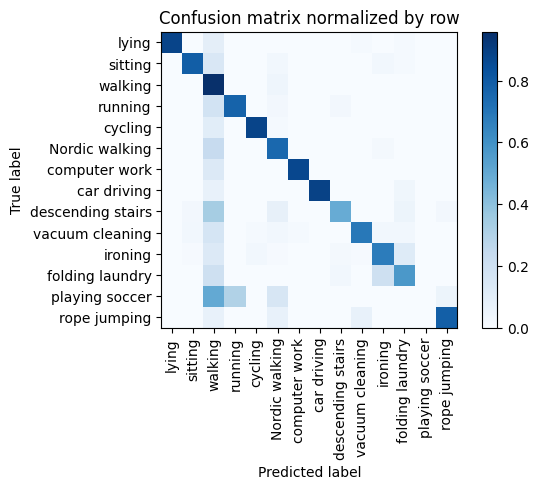

Training Epoch:  90%|█████████ | 9/10 [00:52<00:05,  5.69s/it]

Overall accuracy: 0.766



eval: 100%|██████████| 26/26 [00:00<00:00, 47.31batch/s, loss=0.00779]


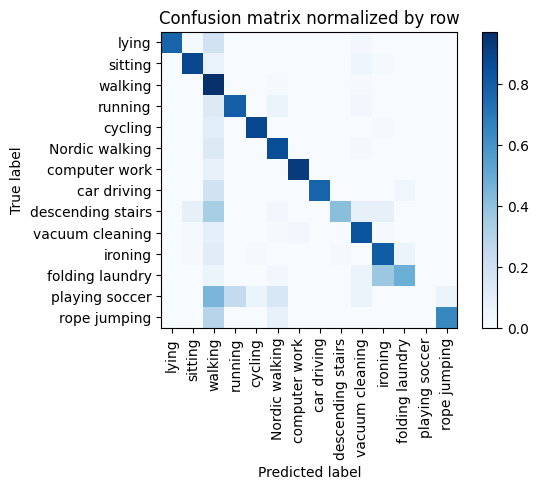

Overall accuracy: 0.799



eval: 100%|██████████| 28/28 [00:00<00:00, 74.36batch/s, loss=0.0203]


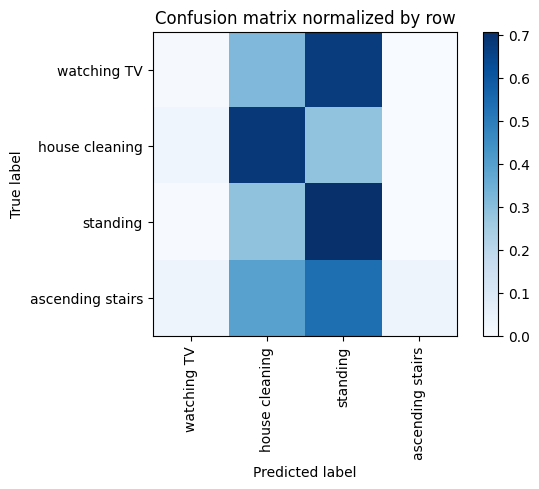

Overall accuracy: 0.465

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.506      0.684      0.582      0.329        288|	 standing: 0.285,	watching TV: 0.031,	
        standing       0.438      0.707      0.541      0.328        287|	 house cleaning: 0.289,	watching TV: 0.003,	
ascending stairs       1.000      0.035      0.067      0.197        173|	 standing: 0.538,	house cleaning: 0.393,	
     watching TV       0.059      0.008      0.014      0.146        128|	 standing: 0.672,	house cleaning: 0.320,	

----------------------------------------------------------------------------------------------------
     avg / total       0.516      0.465      0.384 0.9999999999999999        876|	      

{'total_accuracy': 0.4646118721461187, 'precision': 0.5006875661575685, 'recall': 0.3584598579683413, 'f1': 0.30085601169243975}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', '

eval: 100%|██████████| 26/26 [00:00<00:00, 47.31batch/s, loss=0.018]


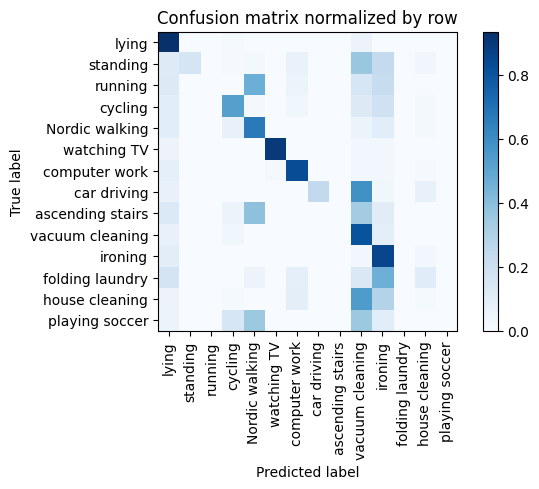

Training Epoch:  10%|█         | 1/10 [00:05<00:47,  5.23s/it]

Overall accuracy: 0.493



eval: 100%|██████████| 26/26 [00:00<00:00, 29.49batch/s, loss=0.0159]


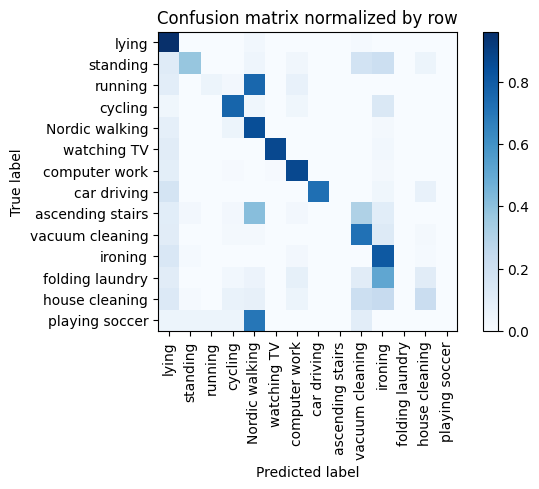

Training Epoch:  20%|██        | 2/10 [00:12<00:51,  6.46s/it]

Overall accuracy: 0.583



eval: 100%|██████████| 26/26 [00:00<00:00, 45.29batch/s, loss=0.0124]


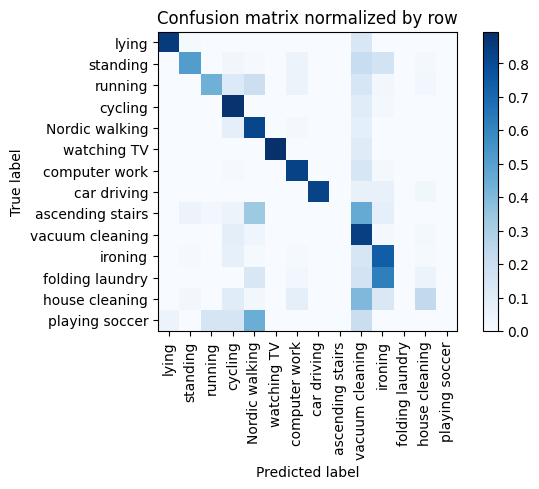

Training Epoch:  30%|███       | 3/10 [00:17<00:40,  5.86s/it]

Overall accuracy: 0.618



eval: 100%|██████████| 26/26 [00:00<00:00, 46.51batch/s, loss=0.0115]


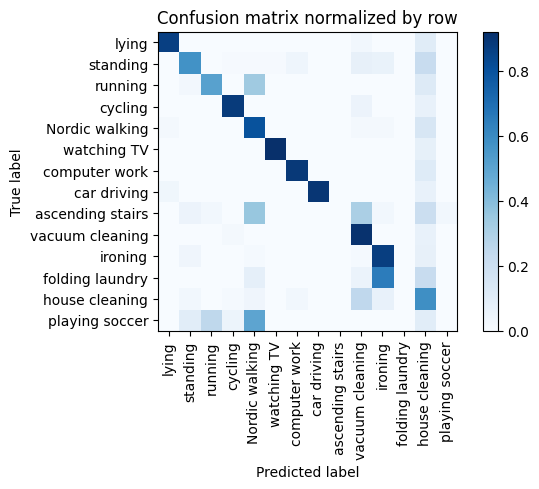

Training Epoch:  40%|████      | 4/10 [00:22<00:33,  5.53s/it]

Overall accuracy: 0.691



eval: 100%|██████████| 26/26 [00:00<00:00, 44.13batch/s, loss=0.0121]


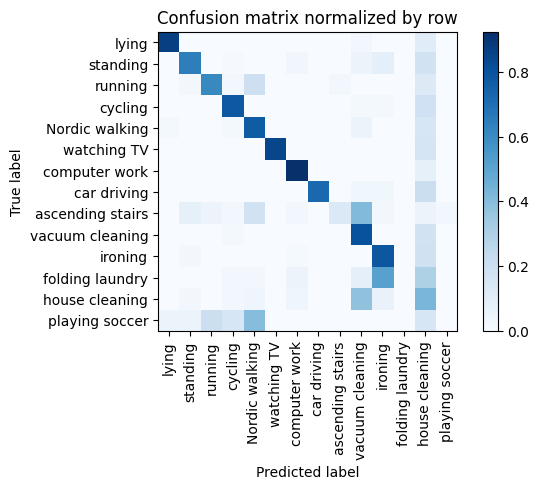

Training Epoch:  50%|█████     | 5/10 [00:27<00:26,  5.37s/it]

Overall accuracy: 0.665



eval: 100%|██████████| 26/26 [00:00<00:00, 46.88batch/s, loss=0.0126]


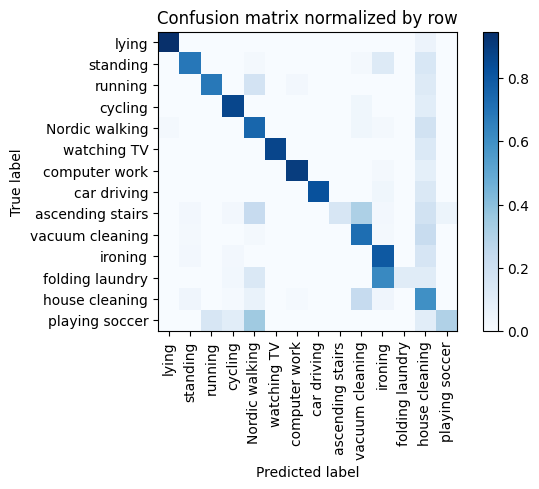

Training Epoch:  60%|██████    | 6/10 [00:32<00:21,  5.26s/it]

Overall accuracy: 0.712



eval: 100%|██████████| 26/26 [00:00<00:00, 48.05batch/s, loss=0.00973]


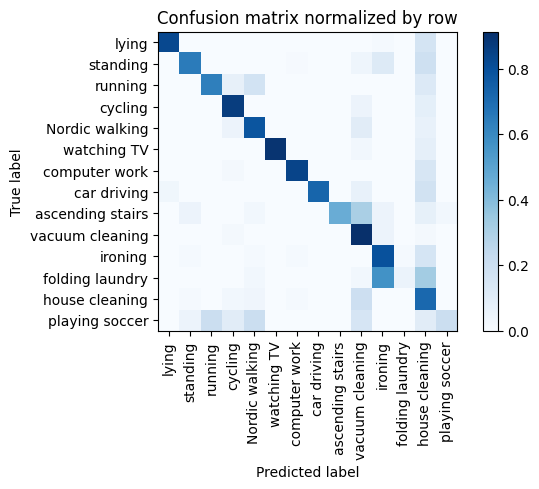

Training Epoch:  70%|███████   | 7/10 [00:37<00:15,  5.17s/it]

Overall accuracy: 0.721



eval: 100%|██████████| 26/26 [00:00<00:00, 28.20batch/s, loss=0.00727]


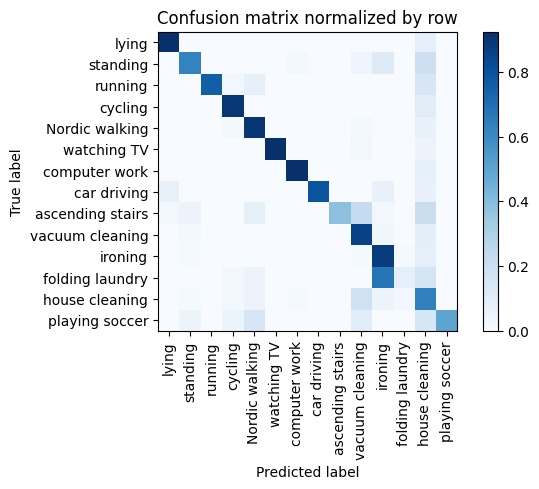

Training Epoch:  80%|████████  | 8/10 [00:45<00:12,  6.12s/it]

Overall accuracy: 0.761



eval: 100%|██████████| 26/26 [00:00<00:00, 46.88batch/s, loss=0.00944]


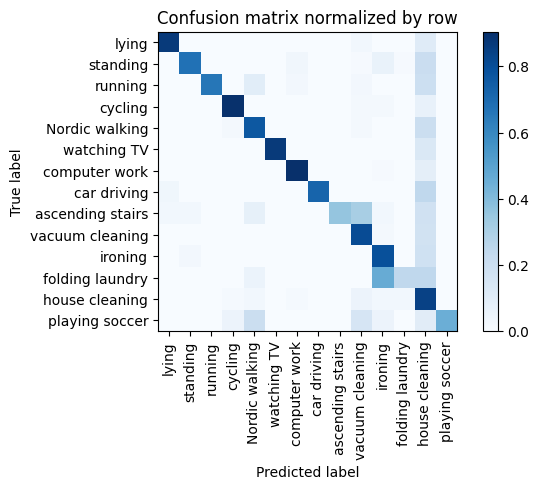

Training Epoch:  90%|█████████ | 9/10 [00:51<00:05,  5.78s/it]

Overall accuracy: 0.752



eval: 100%|██████████| 26/26 [00:00<00:00, 46.80batch/s, loss=0.00714]


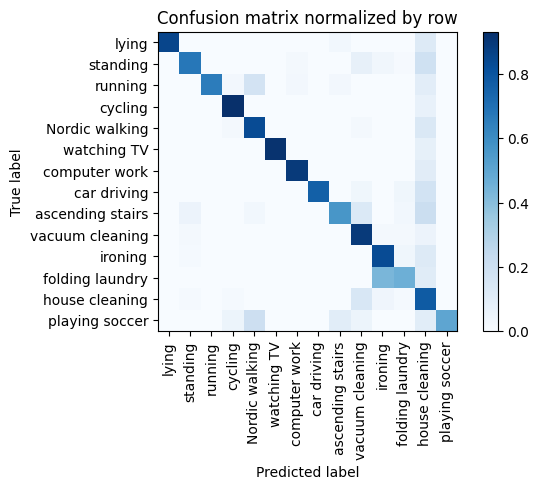

Overall accuracy: 0.786



eval: 100%|██████████| 28/28 [00:00<00:00, 73.30batch/s, loss=0.0201]


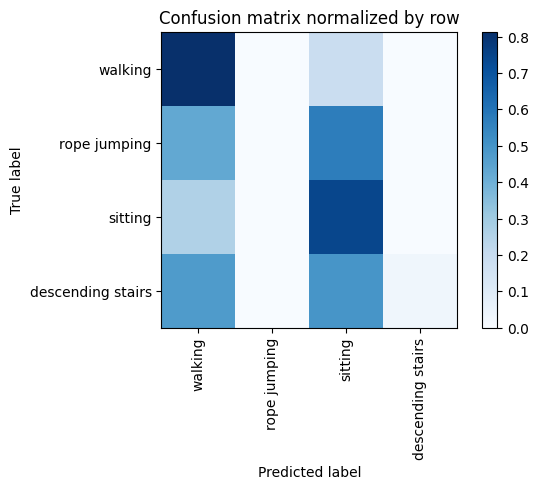

Overall accuracy: 0.584

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.631      0.814      0.711      0.424        370|	 sitting: 0.186,	descending stairs: 0.000,	
          sitting       0.522      0.742      0.613      0.315        275|	 walking: 0.258,	descending stairs: 0.000,	
descending stairs       1.000      0.032      0.061      0.181        158|	 sitting: 0.494,	walking: 0.475,	
     rope jumping       0.000      0.000      0.000      0.080         70|	 sitting: 0.571,	walking: 0.429,	descending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.613      0.584      0.505        1.0        873|	      

{'total_accuracy': 0.584192439862543, 'precision': 0.5381915960258864, 'recall': 0.3967443162379871, 'f1': 0.34617652687925976}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', '

eval: 100%|██████████| 24/24 [00:00<00:00, 51.31batch/s, loss=0.0172]


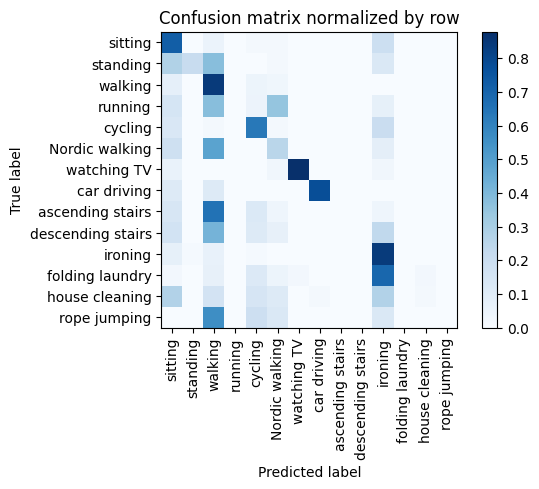

Training Epoch:  10%|█         | 1/10 [00:04<00:42,  4.70s/it]

Overall accuracy: 0.413



eval: 100%|██████████| 24/24 [00:00<00:00, 48.92batch/s, loss=0.015]


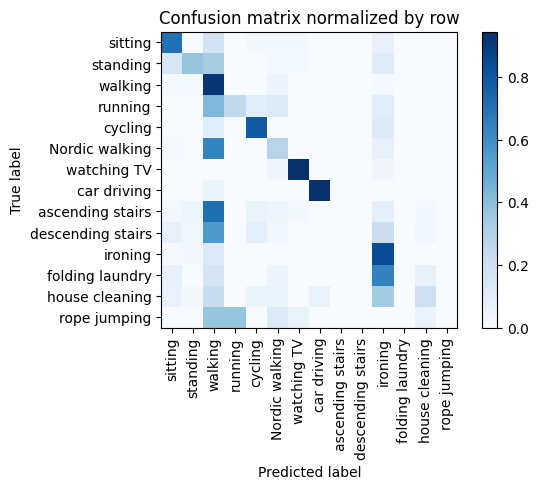

Training Epoch:  20%|██        | 2/10 [00:09<00:36,  4.60s/it]

Overall accuracy: 0.485



eval: 100%|██████████| 24/24 [00:00<00:00, 46.77batch/s, loss=0.0147]


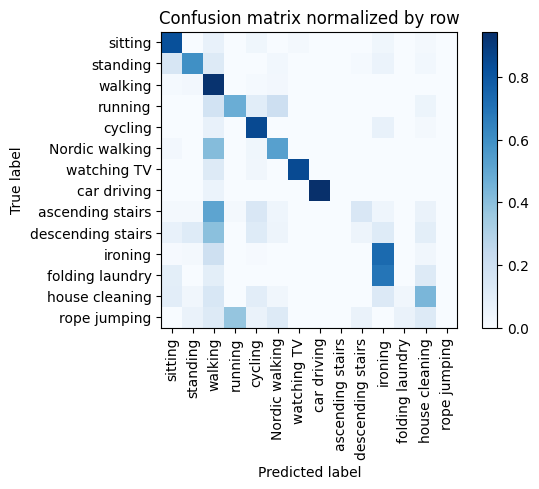

Training Epoch:  30%|███       | 3/10 [00:13<00:32,  4.58s/it]

Overall accuracy: 0.567



eval: 100%|██████████| 24/24 [00:00<00:00, 49.08batch/s, loss=0.0104]


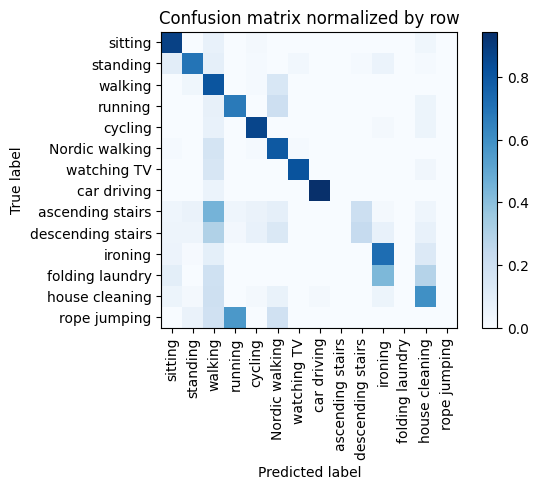

Training Epoch:  40%|████      | 4/10 [00:18<00:27,  4.58s/it]

Overall accuracy: 0.628



eval: 100%|██████████| 24/24 [00:00<00:00, 48.09batch/s, loss=0.013]


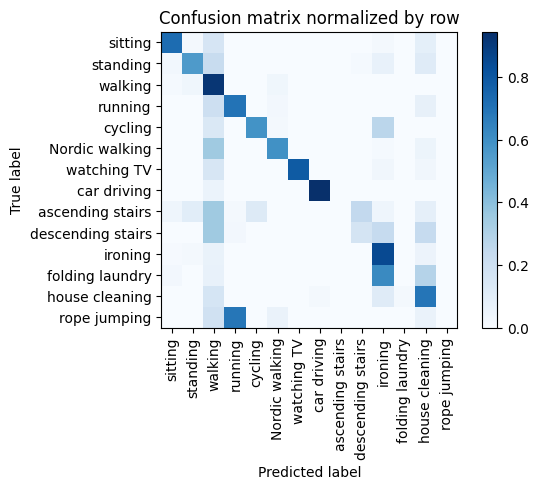

Training Epoch:  50%|█████     | 5/10 [00:22<00:22,  4.59s/it]

Overall accuracy: 0.591



eval: 100%|██████████| 24/24 [00:00<00:00, 47.60batch/s, loss=0.0135]


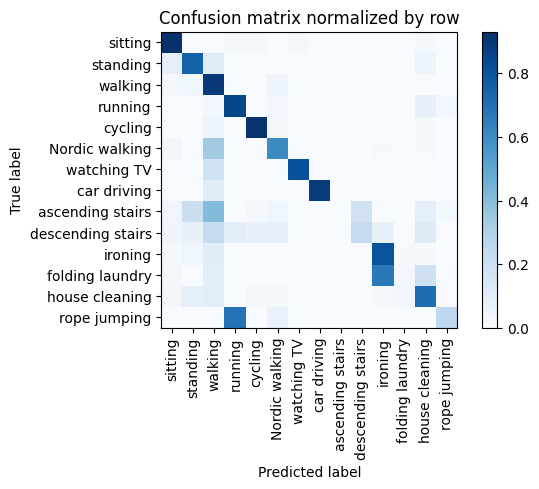

Training Epoch:  60%|██████    | 6/10 [00:27<00:18,  4.62s/it]

Overall accuracy: 0.665



eval: 100%|██████████| 24/24 [00:00<00:00, 46.95batch/s, loss=0.0115]


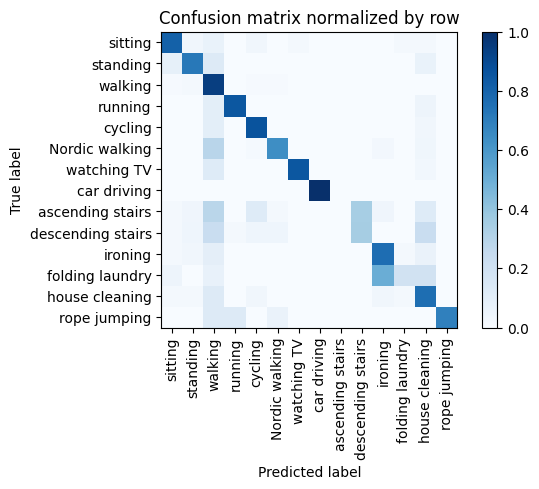

Training Epoch:  70%|███████   | 7/10 [00:32<00:13,  4.63s/it]

Overall accuracy: 0.686



eval: 100%|██████████| 24/24 [00:00<00:00, 48.93batch/s, loss=0.0118]


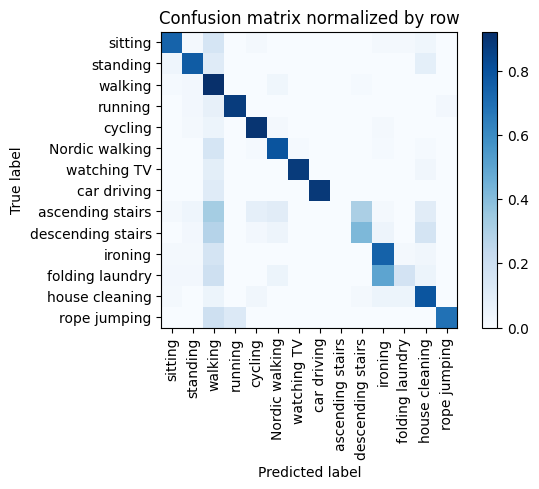

Training Epoch:  80%|████████  | 8/10 [00:36<00:09,  4.63s/it]

Overall accuracy: 0.704



eval: 100%|██████████| 24/24 [00:00<00:00, 49.59batch/s, loss=0.00852]


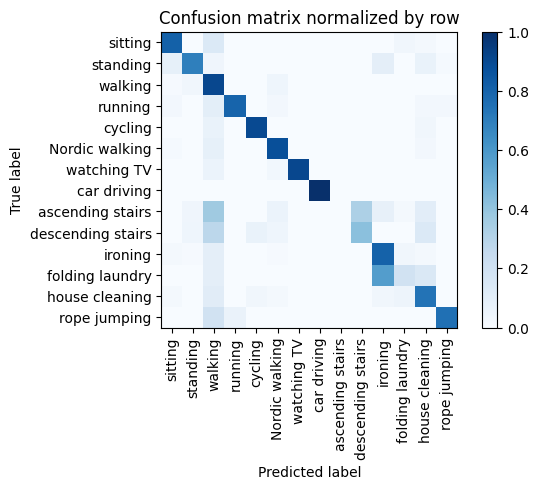

Training Epoch:  90%|█████████ | 9/10 [00:41<00:04,  4.62s/it]

Overall accuracy: 0.718



eval: 100%|██████████| 24/24 [00:00<00:00, 45.98batch/s, loss=0.0081]


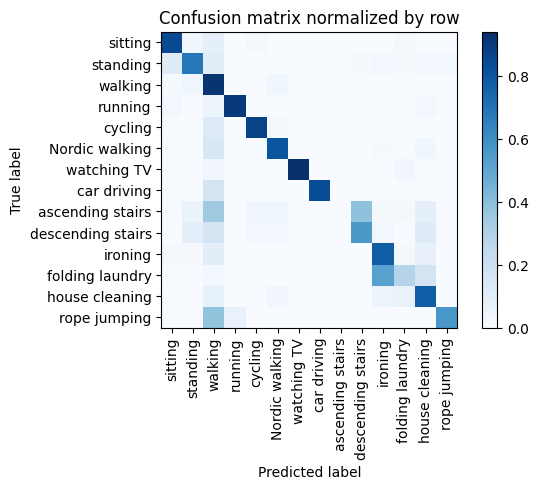

Overall accuracy: 0.720



eval: 100%|██████████| 35/35 [00:00<00:00, 56.73batch/s, loss=0.0288]


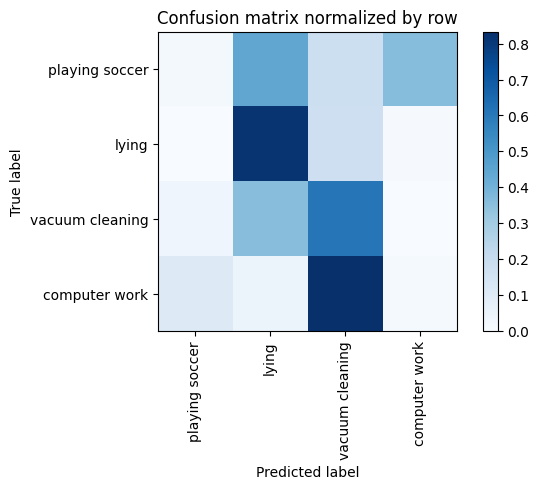

Overall accuracy: 0.373

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.176      0.013      0.024      0.423        467|	 vacuum cleaning: 0.833,	playing soccer: 0.105,	lying: 0.049,	
          lying       0.609      0.815      0.697      0.264        292|	 vacuum cleaning: 0.178,	computer work: 0.007,	
vacuum cleaning       0.269      0.609      0.373      0.248        274|	 lying: 0.358,	playing soccer: 0.033,	
 playing soccer       0.017      0.014      0.015      0.065         72|	 lying: 0.444,	computer work: 0.361,	vacuum cleaning: 0.181,	

----------------------------------------------------------------------------------------------------
    avg / total       0.303      0.373      0.288        1.0       1105|	      

{'total_accuracy': 0.3728506787330317, 'precision': 0.26775912198990787, 'recall': 0.3628235997183056, 'f1': 0.2773322395879479}
================ Fold-3 ================
Unseen Classes : ['cycling'

eval: 100%|██████████| 27/27 [00:00<00:00, 49.91batch/s, loss=0.0169]


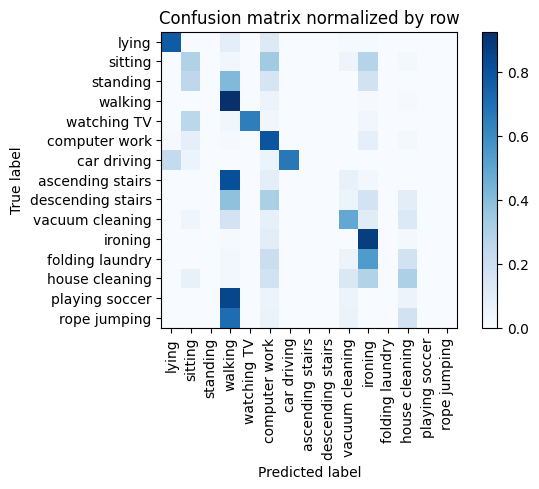

Training Epoch:  10%|█         | 1/10 [00:05<00:48,  5.36s/it]

Overall accuracy: 0.491



eval: 100%|██████████| 27/27 [00:00<00:00, 48.57batch/s, loss=0.0108]


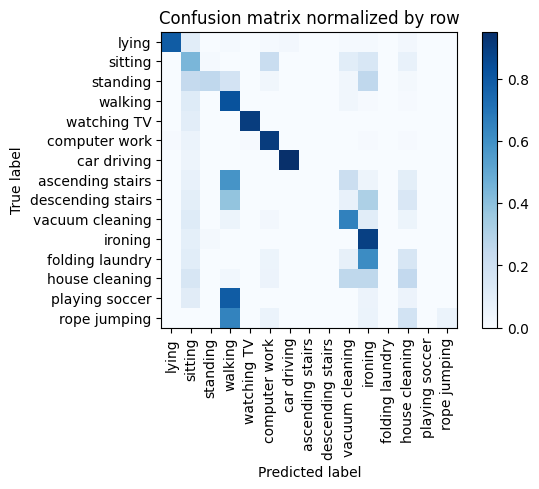

Training Epoch:  20%|██        | 2/10 [00:10<00:42,  5.26s/it]

Overall accuracy: 0.557



eval: 100%|██████████| 27/27 [00:00<00:00, 48.02batch/s, loss=0.00823]


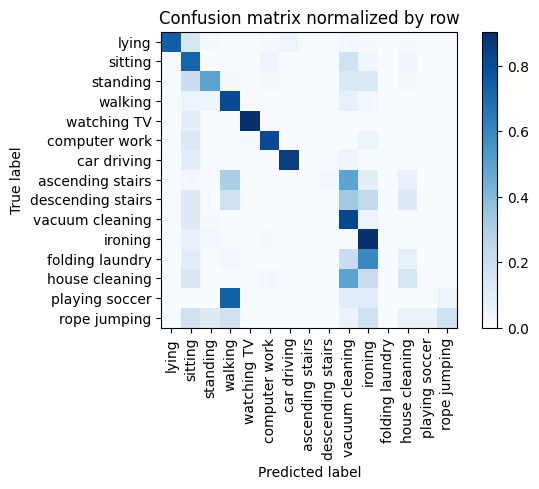

Training Epoch:  30%|███       | 3/10 [00:15<00:36,  5.26s/it]

Overall accuracy: 0.585



eval: 100%|██████████| 27/27 [00:00<00:00, 50.64batch/s, loss=0.0111]


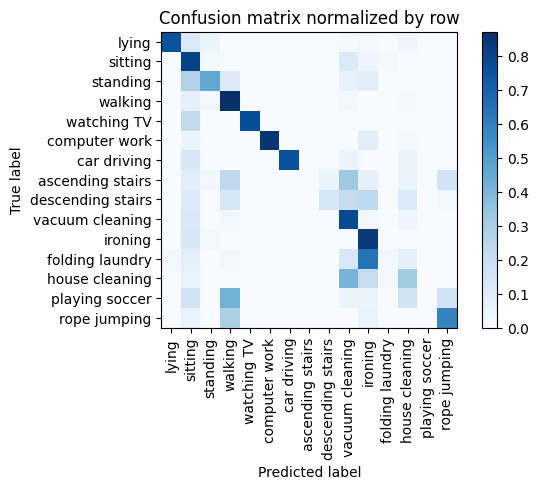

Training Epoch:  40%|████      | 4/10 [00:21<00:31,  5.28s/it]

Overall accuracy: 0.616



eval: 100%|██████████| 27/27 [00:00<00:00, 48.46batch/s, loss=0.00843]


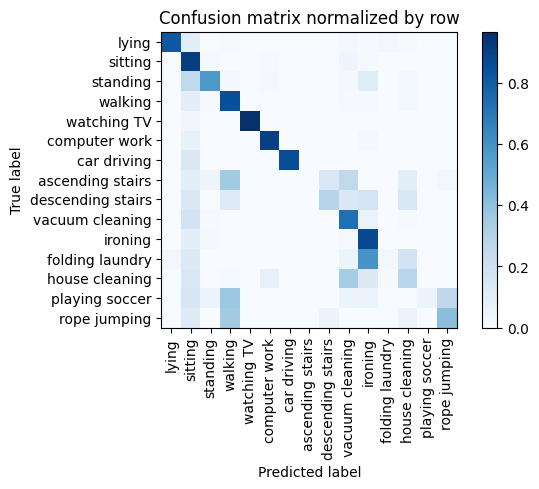

Training Epoch:  50%|█████     | 5/10 [00:26<00:26,  5.23s/it]

Overall accuracy: 0.652



eval: 100%|██████████| 27/27 [00:00<00:00, 44.00batch/s, loss=0.00936]


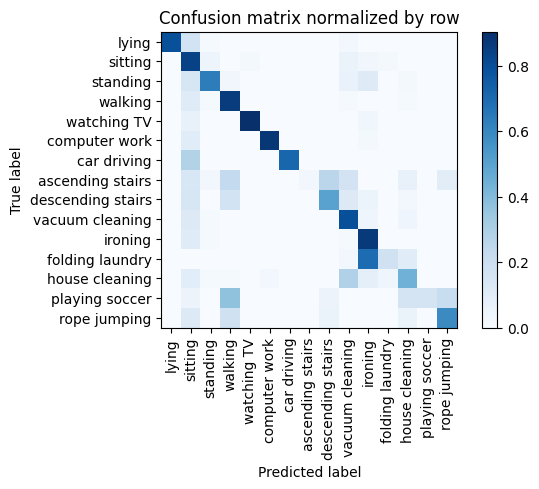

Training Epoch:  60%|██████    | 6/10 [00:31<00:21,  5.26s/it]

Overall accuracy: 0.685



eval: 100%|██████████| 27/27 [00:00<00:00, 47.28batch/s, loss=0.00683]


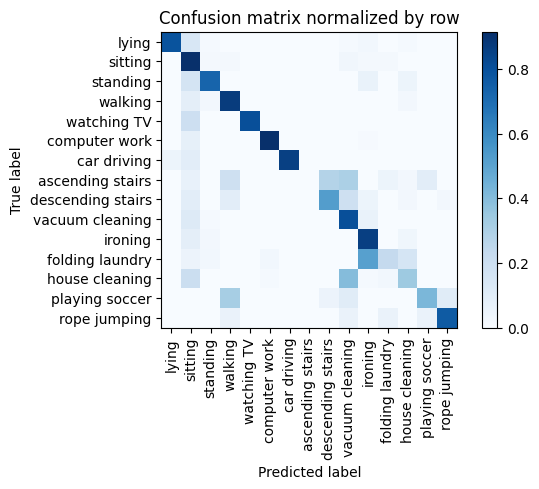

Training Epoch:  70%|███████   | 7/10 [00:37<00:15,  5.32s/it]

Overall accuracy: 0.707



eval: 100%|██████████| 27/27 [00:00<00:00, 46.67batch/s, loss=0.0104]


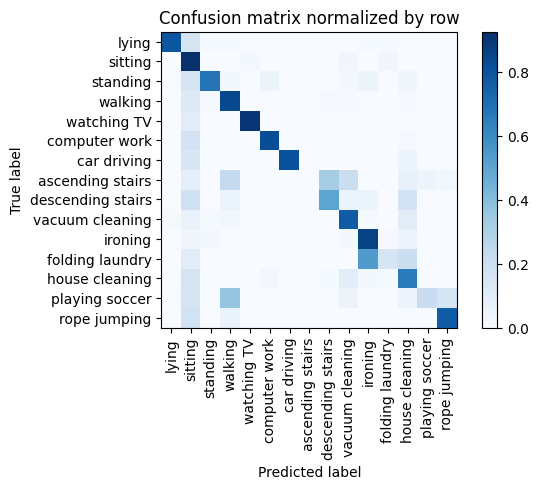

Training Epoch:  80%|████████  | 8/10 [00:42<00:10,  5.30s/it]

Overall accuracy: 0.706



eval: 100%|██████████| 27/27 [00:00<00:00, 49.36batch/s, loss=0.0085]


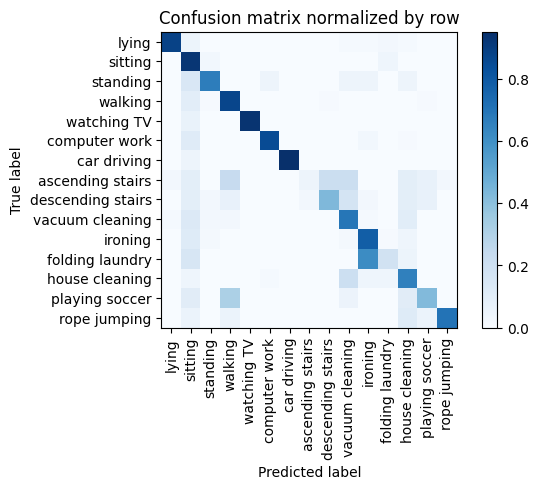

Training Epoch:  90%|█████████ | 9/10 [00:47<00:05,  5.28s/it]

Overall accuracy: 0.713



eval: 100%|██████████| 27/27 [00:00<00:00, 48.63batch/s, loss=0.00855]


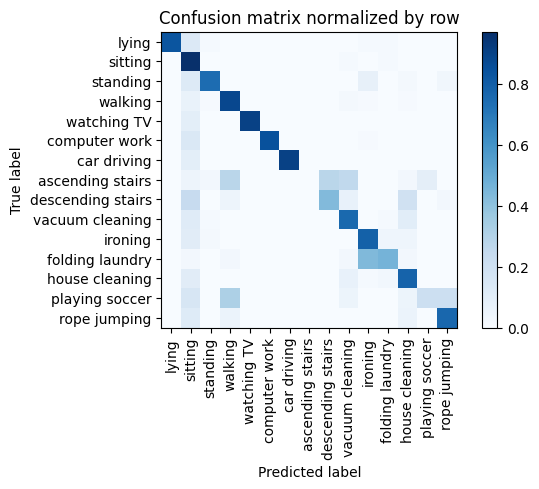

Overall accuracy: 0.739



eval: 100%|██████████| 22/22 [00:00<00:00, 74.07batch/s, loss=0.0238]


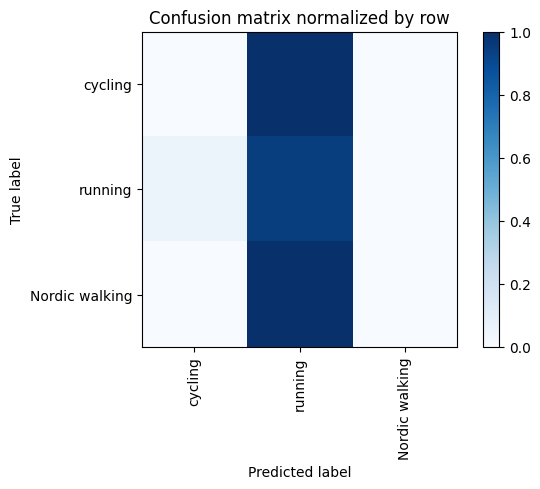

Overall accuracy: 0.207

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.419        287|	 running: 1.000,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.362        248|	 running: 1.000,	Nordic walking: 0.000,	
       running       0.210      0.947      0.343      0.219        150|	 cycling: 0.053,	Nordic walking: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.046      0.207      0.075        1.0        685|	      

{'total_accuracy': 0.2072992700729927, 'precision': 0.06991629739044805, 'recall': 0.31555555555555553, 'f1': 0.11446997178557033}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 47.29batch/s, loss=0.0124]


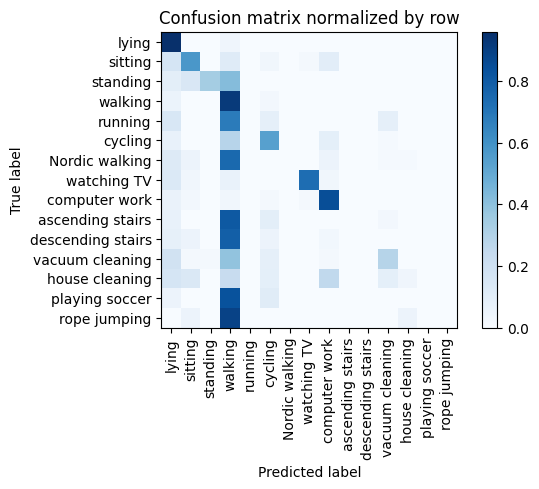

Training Epoch:  10%|█         | 1/10 [00:07<01:03,  7.03s/it]

Overall accuracy: 0.446



eval: 100%|██████████| 28/28 [00:00<00:00, 46.13batch/s, loss=0.0132]


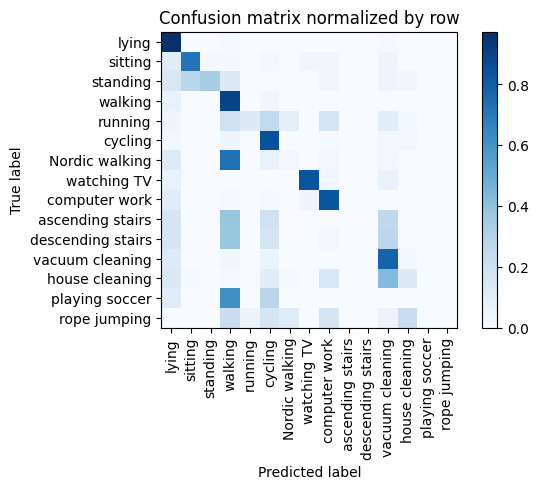

Training Epoch:  20%|██        | 2/10 [00:12<00:48,  6.12s/it]

Overall accuracy: 0.530



eval: 100%|██████████| 28/28 [00:00<00:00, 48.60batch/s, loss=0.0146]


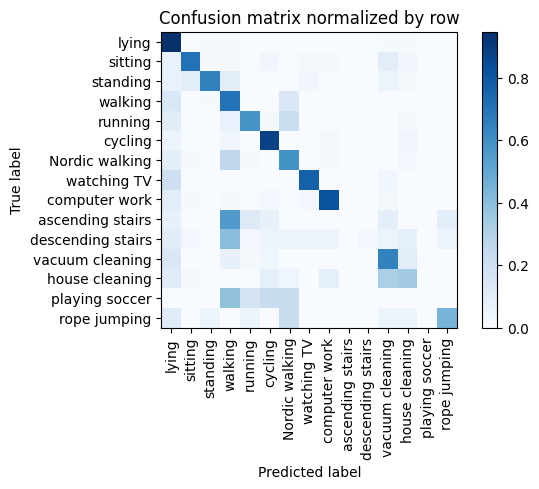

Training Epoch:  30%|███       | 3/10 [00:17<00:40,  5.77s/it]

Overall accuracy: 0.618



eval: 100%|██████████| 28/28 [00:00<00:00, 46.34batch/s, loss=0.0102]


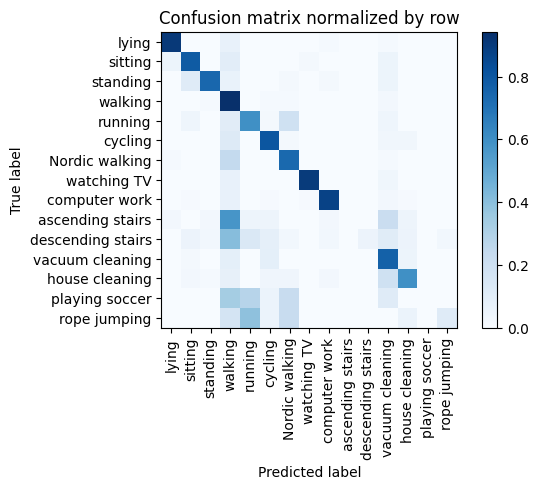

Training Epoch:  40%|████      | 4/10 [00:24<00:35,  5.92s/it]

Overall accuracy: 0.696



eval: 100%|██████████| 28/28 [00:00<00:00, 46.13batch/s, loss=0.00861]


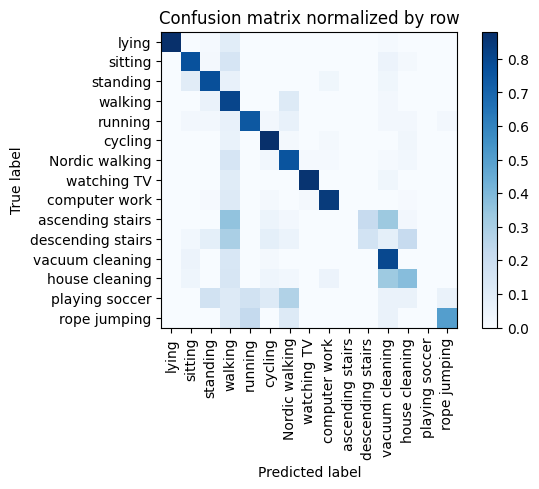

Training Epoch:  50%|█████     | 5/10 [00:29<00:29,  5.81s/it]

Overall accuracy: 0.687



eval: 100%|██████████| 28/28 [00:00<00:00, 45.15batch/s, loss=0.011]


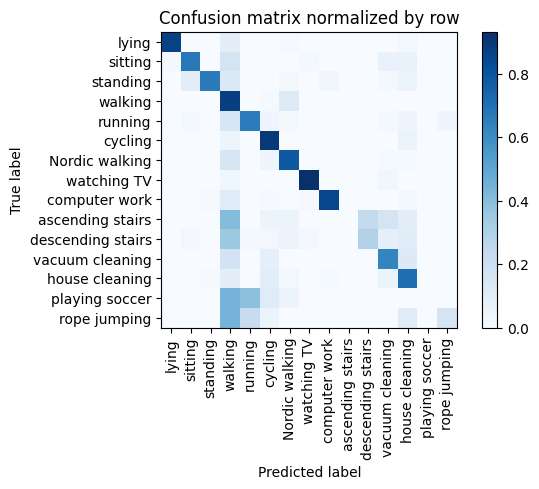

Training Epoch:  60%|██████    | 6/10 [00:35<00:23,  5.80s/it]

Overall accuracy: 0.697



eval: 100%|██████████| 28/28 [00:00<00:00, 47.26batch/s, loss=0.00896]


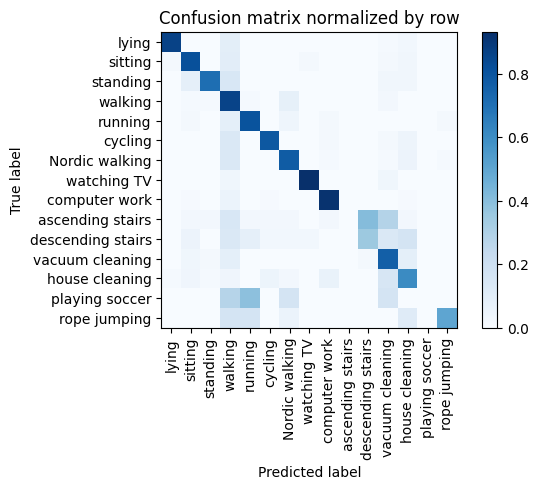

Training Epoch:  70%|███████   | 7/10 [00:40<00:17,  5.73s/it]

Overall accuracy: 0.728



eval: 100%|██████████| 28/28 [00:00<00:00, 40.76batch/s, loss=0.00845]


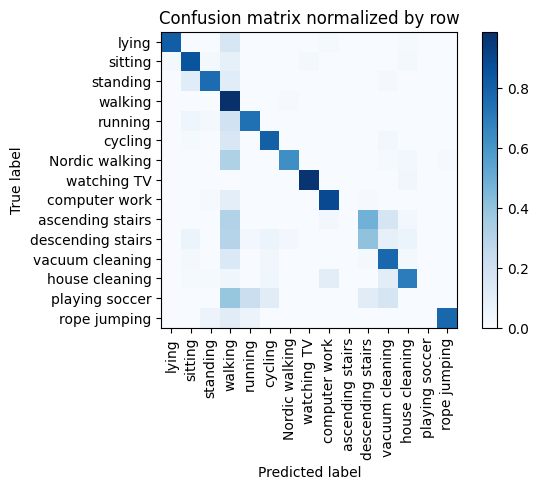

Training Epoch:  80%|████████  | 8/10 [00:46<00:11,  5.75s/it]

Overall accuracy: 0.740



eval: 100%|██████████| 28/28 [00:00<00:00, 47.22batch/s, loss=0.00632]


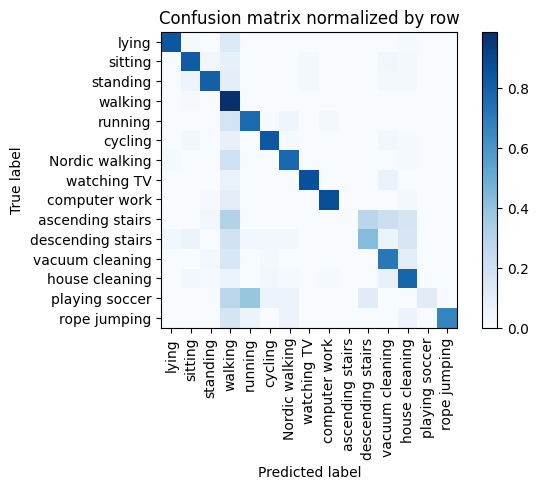

Training Epoch:  90%|█████████ | 9/10 [00:52<00:05,  5.73s/it]

Overall accuracy: 0.758



eval: 100%|██████████| 28/28 [00:01<00:00, 23.64batch/s, loss=0.00735]


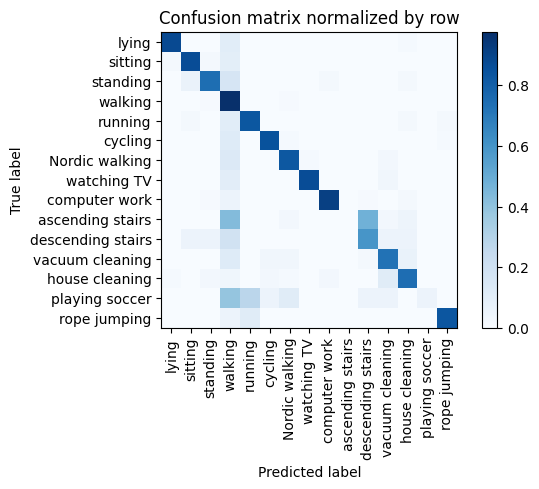

Overall accuracy: 0.781



eval: 100%|██████████| 19/19 [00:00<00:00, 64.08batch/s, loss=0.036] 


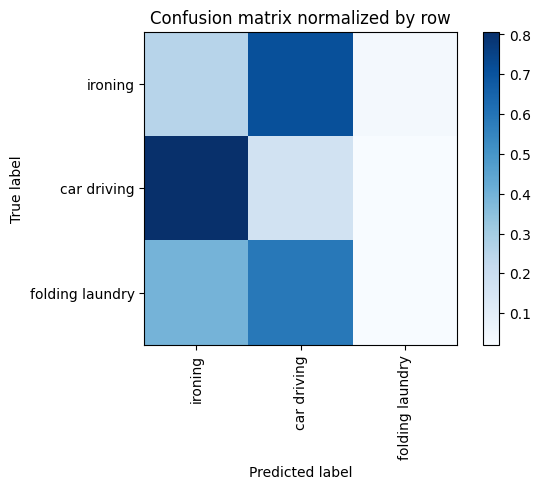

Overall accuracy: 0.184

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.418      0.251      0.314      0.611        366|	 car driving: 0.710,	folding laundry: 0.038,	
folding laundry       0.158      0.021      0.037      0.242        145|	 car driving: 0.586,	ironing: 0.393,	
    car driving       0.042      0.170      0.067      0.147         88|	 ironing: 0.807,	folding laundry: 0.023,	

----------------------------------------------------------------------------------------------------
    avg / total       0.300      0.184      0.211        1.0        599|	      

{'total_accuracy': 0.18363939899833054, 'precision': 0.2059144072301967, 'recall': 0.14750344028184617, 'f1': 0.1391809418764592}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.362519
precision         0.316494
recall            0.316217
f1                0.235603
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model12(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
        # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    